In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet.plot import plot_plotly
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from datetime import datetime, timedelta
from scipy import stats
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [59]:

def carregar_dados(caminho_csv):
    df = pd.read_csv(caminho_csv)
    df["data_dia"] = pd.to_datetime(df["data_dia"])
    return df

In [60]:
def filtrar_sku_periodo(df, sku, inicio, fim):
    return df[(df["data_dia"] >= inicio) &
              (df["data_dia"] <= fim) &
              (df["id_produto"] == sku)]


In [61]:
def calcular_estatisticas(df_retirada):
    df_retirada = df_retirada.copy()  # Evita SettingWithCopyWarning
    media = df_retirada['total_venda_dia_kg'].mean()
    df_retirada.loc[:, "media"] = media
    df_retirada.loc[:, "peso_perdido"] = df_retirada["total_venda_dia_kg"] * 0.15
    df_retirada.loc[:, "colocar_descongelar"] = df_retirada["total_venda_dia_kg"] + df_retirada["peso_perdido"]
    return df_retirada

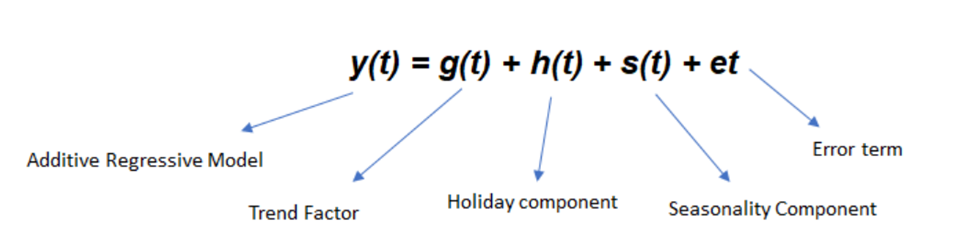

In [62]:
def preparar_dados_prophet(df_filtrado_csv):
    df = pd.read_csv(df_filtrado_csv, sep=';')
    df.rename(columns={'data_dia': 'ds', 'total_venda_dia_kg': 'y'}, inplace=True)
    df['ds'] = pd.to_datetime(df['ds'])
    z_scores = stats.zscore(df["y"])
    df_sem_outliers = df[(z_scores > -3) & (z_scores < 3)].copy()
    return df_sem_outliers

In [63]:
def treinar_modelo(df_sem_outliers):
    m = Prophet()
    m.fit(df_sem_outliers)
    return m


In [64]:
def prever_demanda(modelo, df_sem_outliers):
    futuro = modelo.make_future_dataframe(periods=365, freq='D')
    previsao = modelo.predict(futuro)

    historico = df_sem_outliers.set_index("ds")
    media_movel_3 = historico["y"].rolling(window=3).mean()
    media_movel_3.name = "media_movel_3"
    media_movel_3 = media_movel_3.reset_index()

    previsao = previsao.merge(media_movel_3, how="left", on="ds")
    previsao["yhat_hibrido"] = 0.7 * previsao["yhat"] + 0.3 * previsao["media_movel_3"]
    previsao["yhat_hibrido"].fillna(previsao["yhat"], inplace=True)

    return previsao

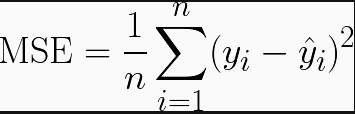

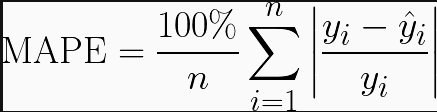

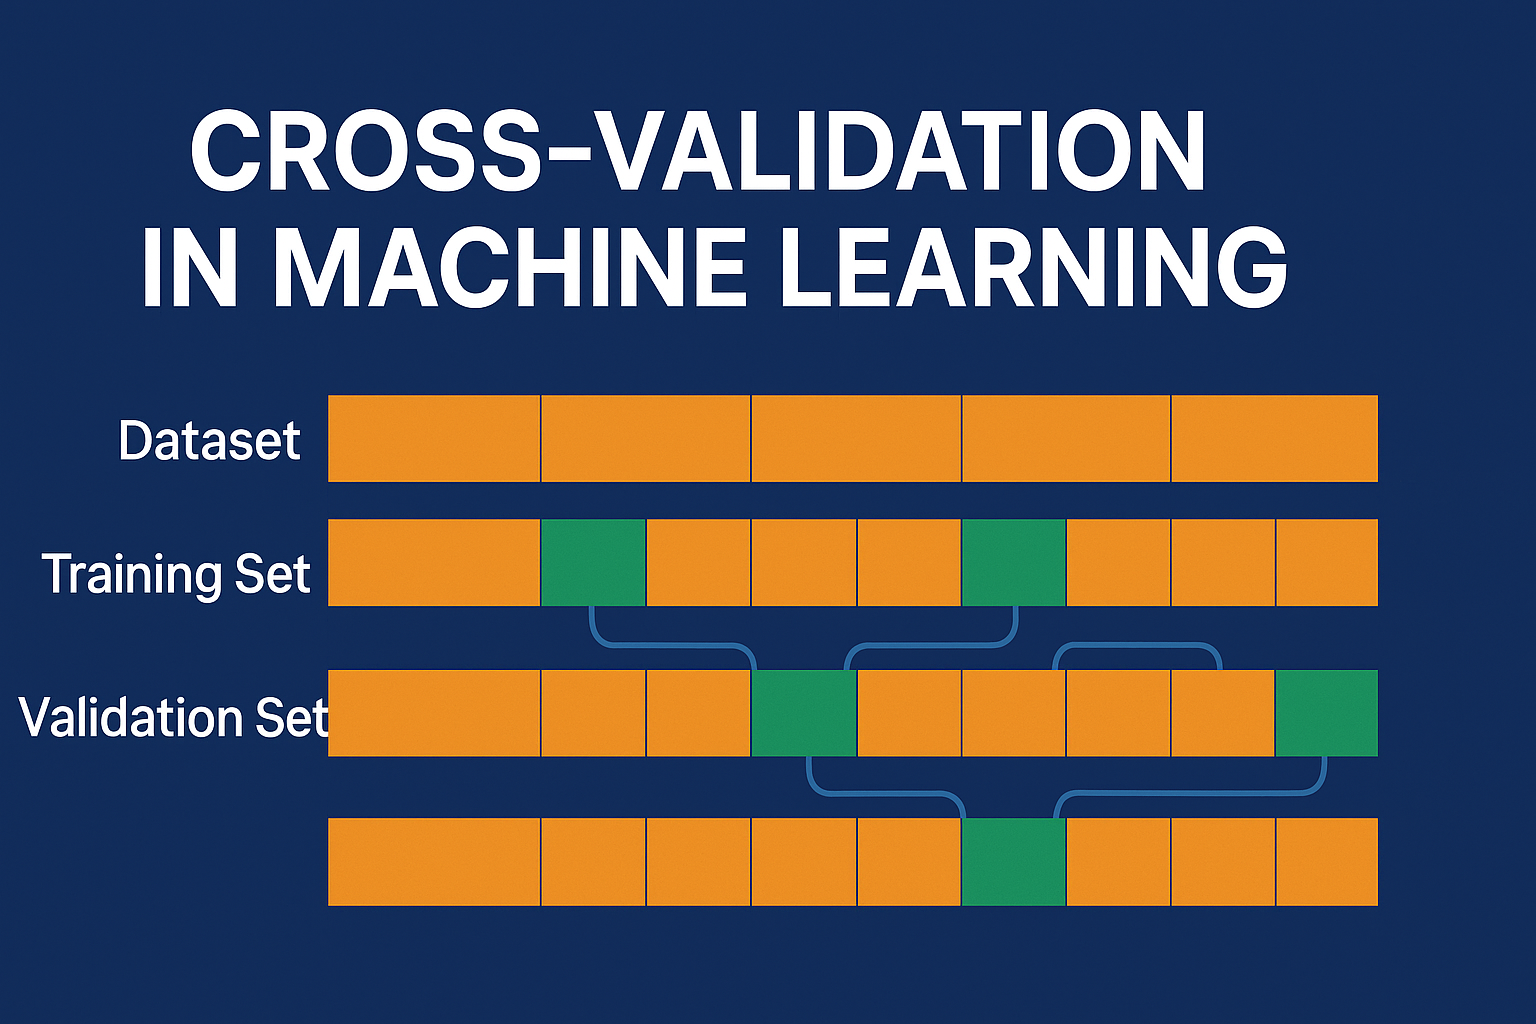

In [65]:
def comparar_erros_prophet_vs_hibrido(modelo, df_sem_outliers):
    from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
    import numpy as np

    # Validação cruzada padrão do Prophet
    df_cv = cross_validation(model=modelo, initial='5 days', period='7 days', horizon='2 days')
    df_cv = df_cv[['ds', 'yhat', 'y']]  # Apenas o necessário

    # Calcular média móvel para as datas de previsão
    historico = df_sem_outliers.set_index("ds")
    media_movel_3 = historico["y"].rolling(window=3).mean()
    media_movel_3.name = "media_movel_3"
    media_movel_3 = media_movel_3.reset_index()
    # Juntar a média móvel ao df_cv
    df_cv = df_cv.merge(media_movel_3, how="left", on="ds")

    # Criar a previsão híbrida
    df_cv["yhat_hibrido"] = 0.7 * df_cv["yhat"] + 0.3 * df_cv["media_movel_3"]
    df_cv["yhat_hibrido"].fillna(df_cv["yhat"], inplace=True)

    # Calcular erros
    mape_prophet = mean_absolute_percentage_error(df_cv["y"], df_cv["yhat"]) * 100
    mse_prophet = mean_squared_error(df_cv["y"], df_cv["yhat"])
    rmse_prophet = np.sqrt(mse_prophet)

    mape_hibrido = mean_absolute_percentage_error(df_cv["y"], df_cv["yhat_hibrido"]) * 100
    mse_hibrido = mean_squared_error(df_cv["y"], df_cv["yhat_hibrido"])
    rmse_hibrido = np.sqrt(mse_hibrido)


    print(f"\n--- COMPARAÇÃO DE ERROS ---")
    print(f"Prophet: MAPE = {mape_prophet:.2f}%, RMSE = {rmse_prophet:.2f} kg")
    print(f"Híbrido: MAPE = {mape_hibrido:.2f}%, RMSE = {rmse_hibrido:.2f} kg")

    display(df_cv)

In [66]:
def gerar_relatorio_diario(previsao, hoje, sku, taxa=0.15):
    data_venda = hoje + timedelta(days=2)
    previsao_d2 = previsao[previsao["ds"] == data_venda]

    if not previsao_d2.empty:
        demanda_prevista = previsao_d2["yhat_hibrido"].values[0]
        if not np.isnan(demanda_prevista):
            retirada_corrigida = demanda_prevista / (1 - taxa)
            relatorio = pd.DataFrame({
                "data_retirada": [hoje.date()],
                "data_venda": [data_venda.date()],
                "SKU": [sku],
                "demanda_prevista_kg": [round(demanda_prevista, 2)],
                "retirada_recomendada_kg": [round(retirada_corrigida, 2)]
            })
            relatorio.to_csv("relatorio_retirada_quantum.csv", index=False)
            print(relatorio)
            return demanda_prevista, retirada_corrigida
        else:
            print(f"Previsão inválida (NaN) para a data {data_venda.date()} — não foi possível gerar o relatório.")
            return None, None
    else:
        print(f"Não há previsão de demanda para a data {data_venda.date()}")
        return None, None

In [67]:
def validar_modelo(modelo):
    df_cv = cross_validation(model=modelo, initial='30 days', period='7 days', horizon='2 days')
    df_metrics = performance_metrics(df_cv)
    mape_medio = df_metrics['mape'].mean() * 100
    rmse_medio = df_metrics['rmse'].mean()

    print(f"MAPE médio: {mape_medio:.2f}%")
    print(f"RMSE médio: {rmse_medio:.2f} kg")

    plt.figure(figsize=(8, 4))
    plt.plot(df_metrics['horizon'], df_metrics['mape'] * 100, label='MAPE (%)', marker='o')
    plt.plot(df_metrics['horizon'], df_metrics['rmse'], label='RMSE (kg)', marker='s')
    plt.xlabel('Horizonte (dias)')
    plt.ylabel('Erro')
    plt.title('Erro de Previsão por Horizonte (D+2)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [68]:
def plotar_comparacao(previsao):
    plt.figure(figsize=(12, 5))
    plt.plot(previsao['ds'], previsao['yhat'], label='Previsão Prophet', color='blue', alpha=0.7)
    plt.plot(previsao['ds'], previsao['yhat_hibrido'], label='Previsão Híbrida', color='green', linestyle='--')
    plt.xlabel('Data')
    plt.ylabel('Demanda Prevista (kg)')
    plt.title('Comparação: Prophet vs Previsão Híbrida')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwezxh5tu/2hn67mwa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwezxh5tu/5ixq0_sz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37452', 'data', 'file=/tmp/tmpwezxh5tu/2hn67mwa.json', 'init=/tmp/tmpwezxh5tu/5ixq0_sz.json', 'output', 'file=/tmp/tmpwezxh5tu/prophet_modelas9gpykr/prophet_model-20250709130702.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:07:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:07:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/tmp/ipython-input-52-63076453.py:12: F

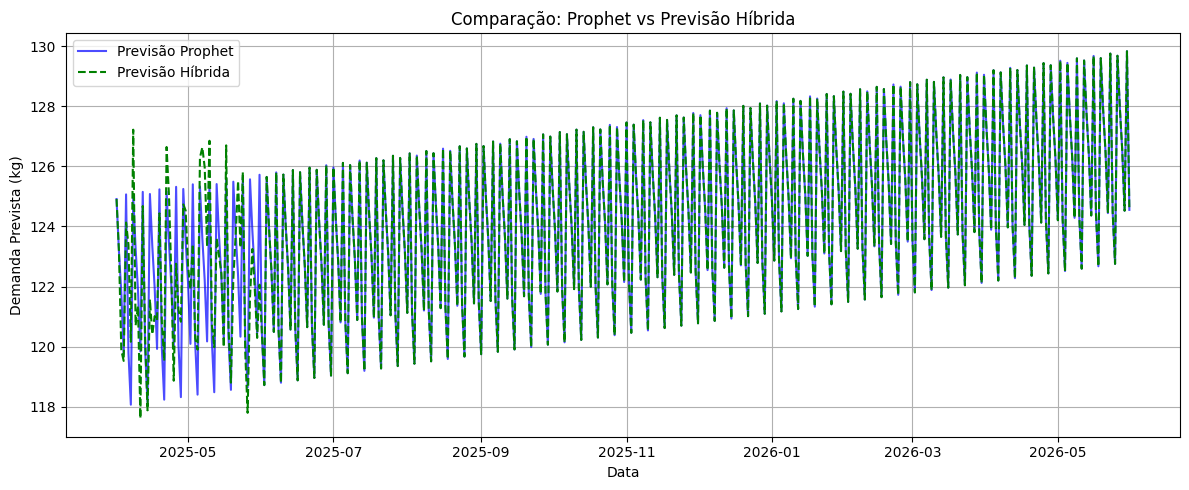

INFO:prophet:Making 5 forecasts with cutoffs between 2025-05-01 00:00:00 and 2025-05-29 00:00:00


  data_retirada  data_venda     SKU  demanda_prevista_kg  \
0    2025-07-09  2025-07-11  237497               120.89   

   retirada_recomendada_kg  
0                   142.22  
Para garantir 120.89 kg de venda, retire 142.22 kg hoje.


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwezxh5tu/g4ilntzq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwezxh5tu/sx1o5rc3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15403', 'data', 'file=/tmp/tmpwezxh5tu/g4ilntzq.json', 'init=/tmp/tmpwezxh5tu/sx1o5rc3.json', 'output', 'file=/tmp/tmpwezxh5tu/prophet_modelc1odqm1t/prophet_model-20250709130705.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:07:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:07:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwezxh5tu/7whr1gl0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwezxh5tu/e5xsec79.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:ru

MAPE médio: 9.26%
RMSE médio: 12.95 kg


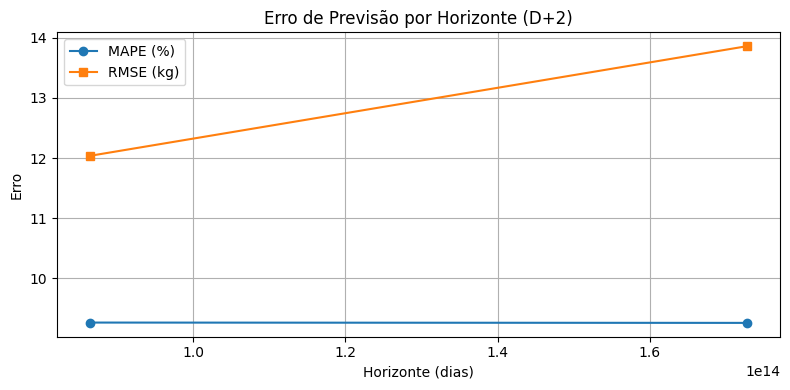

INFO:prophet:Making 8 forecasts with cutoffs between 2025-04-10 00:00:00 and 2025-05-29 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwezxh5tu/n170ftsr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwezxh5tu/8lpdi9zs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86761', 'data', 'file=/tmp/tmpwezxh5tu/n170ftsr.json', 'init=/tmp/tmpwezxh5tu/8lpdi9zs.json', 'output', 'file=/tmp/tmpwezxh5tu/prophet_modelop1qp9_7/prophet_model-20250709130707.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:07:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:07:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwezxh5tu/8pnro0y6.json
DEBUG:cmdstanpy:input tempfil


--- COMPARAÇÃO DE ERROS ---
Prophet: MAPE = 8.72%, RMSE = 12.32 kg
Híbrido: MAPE = 7.83%, RMSE = 11.14 kg


/tmp/ipython-input-53-1787530798.py:19: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,ds,yhat,y,media_movel_3,yhat_hibrido
0,2025-04-11,126.092721,128.82,112.420000,121.990904
1,2025-04-12,134.323163,124.21,123.583333,131.101214
2,2025-04-18,125.639422,125.36,123.086667,124.873595
3,2025-04-19,127.449266,109.61,122.570000,125.985486
4,2025-04-25,127.669800,111.60,116.203333,124.229860
5,2025-04-26,123.668393,131.21,116.793333,121.605875
6,2025-05-02,124.825011,128.21,126.166667,125.227507
7,2025-05-03,126.696945,116.97,118.770000,124.318861
8,2025-05-09,129.111644,120.32,130.700000,129.588151
9,2025-05-10,128.361502,130.23,130.043333,128.866051


In [57]:
def main():
    sku = 237497
    hoje = pd.to_datetime(datetime.today().date())

    df = carregar_dados("dados_vendas_sinteticos.csv")
    df_retirada = filtrar_sku_periodo(df, sku, "2025-04-01", "2025-05-31")
    df_retirada = calcular_estatisticas(df_retirada)
    df_retirada.to_csv("vendas_filtradas_quantum.csv", index=False, encoding="latin1", sep=";")

    df_sem_outliers = preparar_dados_prophet("vendas_filtradas_quantum.csv")
    modelo = treinar_modelo(df_sem_outliers)
    previsao = prever_demanda(modelo, df_sem_outliers)

    plot_plotly(modelo, previsao).show()
    plotar_comparacao(previsao)

    demanda_prevista, retirada_corrigida = gerar_relatorio_diario(previsao, hoje, sku)

    if demanda_prevista:
        print(f"Para garantir {demanda_prevista:.2f} kg de venda, retire {retirada_corrigida:.2f} kg hoje.")

    validar_modelo(modelo)
    comparar_erros_prophet_vs_hibrido(modelo, df_sem_outliers)
if __name__ == "__main__":
    main()